In [1]:
import numpy as np
import math
from scipy.linalg import expm
from numpy import linalg as LA
from functools import cache
from math import factorial as fact
from tqdm import tqdm
import matplotlib.pyplot as plt
from cycler import cycler
import pandas as pd
from scipy.interpolate import interp1d
from scipy.interpolate import splrep
from scipy import interpolate

markers = ["o", "x", "s"]
linestyles = ['-', '--', '-.', ':', '-']

In [2]:
D_0 = np.matrix([
    [-0.405780, 0],
    [0, -0.013173]
])


In [3]:
D_1 = np.matrix([
    [0.403080, 0.0027],
    [0.007338, 0.005835]
])

In [4]:
matrix_size = 2
lambd = 0.3
gamma = 0.4
epsilon = 1e-7
epsilon_f = 1e-10
b_1 = 1
K = 4


In [5]:
#D_0 = np.matrix([-lambd])
#D_1 = np.matrix([lambd])


In [6]:
h = np.diag(-D_0).max()

In [7]:
W = len(D_0) - 1

In [8]:
matrix_size = len(D_0)

In [9]:
O = np.matrix(np.zeros((W + 1, W + 1)))

In [10]:
I = np.matrix(np.identity(W + 1))

$$\varphi_k(t)$$

In [11]:
@cache
def varphi_k_t(k, t):
    return (gamma * t)**k / math.factorial(k) * math.exp(-gamma*t)

$$\hat\varphi_k(t)$$

In [12]:
@cache
def hat_varphi_k_t(k, t):
    norm = 1
    summa = 0
    i = 0
    while norm > epsilon:
        norm = varphi_k_t(k + i, t)
        summa += norm
        i += 1
    return summa

$$\varphi_k$$

In [13]:
@cache
def varphi_k(k):
    return varphi_k_t(k, b_1)

$$\hat\varphi_k$$

In [14]:
@cache
def hat_varphi_k(k):
    norm = 1
    summa = 0
    i = 0
    while norm > epsilon:
        norm = varphi_k(k + i)
        summa += norm
        i += 1
    return summa

$$\sum\limits_{i=0}^{\infty}P(i,t)z^i=e^{(D_0+D_1z)t}$$

In [15]:
@cache
def P_i_t_z(z, t):
    return expm((D_0 + D_1 * z) * t)

$$K_n^{(j)}$$

In [16]:
@cache
def K_n(n, j):
    if j == 0 and n == 0:
        return I.copy()
    elif j == 0 and n >= 1:
        return O.copy()
    elif n == 0:
        return K_n(0, j - 1) * (I + D_0 / h)
    elif n>=1 and j>=1:
        return K_n(n - 1, j-1) * D_1 / h + K_n(n, j-1) * (I + D_0 / h)


$$\Phi(i,k)$$

In [17]:
@cache
def Phi_i_k(i, k):
    norm = 1
    j = 0
    summa = 0
    while norm > epsilon or norm == 0:
        try:
            element = (h * b_1)**j / fact(j) * K_n(i, j)
        except:
            break
        norm = LA.norm(element)
        summa += element
        j += 1
    return np.exp(-(h + gamma) * b_1) * (gamma * b_1)**k / fact(k) * summa

$$\hat\Phi(i,k)$$

In [18]:
@cache
def gamma_b_1_l(l):
    mul = 1
    for z in (gamma * b_1 / x for x in range(1, l + 1)):
        mul *= z
    return mul

@cache
def hat_Phi_i_k(i, k):
    # First summ
    norm = 1
    j = 0
    summa_1 = 0
    while norm > epsilon or norm == 0:
        try:
            element = (h * b_1)**j / fact(j) * K_n(i, j)
        except:
            break
        norm = LA.norm(element)
        summa_1 += element
        j += 1
    # Second sum
    norm = 1
    l = k
    summa_2 = 0
    while norm > epsilon or norm == 0:
        #element = (gamma * b_1)**l / fact(l)
        element = gamma_b_1_l(l)
        norm = LA.norm(element)
        summa_2 += element
        l += 1
    return np.exp(-(h + gamma) * b_1) * summa_1 * summa_2

$$N(m)$$

$$ N(m) =\frac{\gamma}{h+\gamma} \sum\limits_{j=0}^{\infty}(\frac{h}{h+\gamma})^jK_m^{(j)},\;$ $m \ge 0$$

In [19]:
@cache
def N(m):
    norm = 1
    j = 0
    summa = 0
    count_null = 0
    while norm > epsilon or count_null < 200:
        element = (h / (h + gamma))**j * K_n(m, j)
        norm = LA.norm(element)
        if norm == 0:
            count_null += 1
        else:
            count_null = 0
        summa += element
        j += 1
    return gamma / (h + gamma) * summa

$$M(r)$$

In [20]:
@cache
def M(r):
    return gamma**r * (-D_0 + gamma * I)**(-(r + 1)) * D_1

$$\hat M(r)$$

In [21]:
@cache
def hat_M(r):
    return gamma**r * (-D_0 + gamma * I)**(-r) * (-D_0)**(-1) * D_1

$$P\left\{(0, 0) \to (j, k' ) \right\}=M(0)\sum\limits_{n = 0}^{j}N(n)\Phi(j-n, k') + N(0)\sum\limits_{m = 0}^{k'}M(m)\Phi(j, k' - m),$$
$$\; k'= {\overline{0,K-2}};$$

In [22]:
@cache
def P_0_0_j_k_(j, k_):
    summa_1 = np.zeros((matrix_size, matrix_size))
    summa_2 = np.zeros((matrix_size, matrix_size))
    for n in range(j + 1):
        summa_1 += N(n) * Phi_i_k(j - n, k_)
    for m in range(k_ + 1):
        summa_2 += M(m) * Phi_i_k(j, k_ - m)
    return M(0) * summa_1 + N(0) * summa_2    


$$P\left\{(0, 0) \to (j,K-1 ) \right\}= N(0)\biggl[\sum\limits_{m = 0}^{K-1}M(m)\Phi(j, K-1 - m)
+\hat {M}(K) \Phi(j, 0)\biggr] $$$$+M(0)\sum\limits_{n = 0}^{j}N(n)\Phi(j-n, K-1);$$

In [23]:
@cache
def P_0_0_j_K_1(j):
    summa_1 = np.zeros((matrix_size, matrix_size))
    summa_2 = np.zeros((matrix_size, matrix_size))
    for m in range(K):
        summa_1 += M(m) * Phi_i_k(j, K - 1 - m)
    summa_1 += hat_M(K) * Phi_i_k(j, 0)

    for n in range(j + 1):
        summa_2 += N(n) * Phi_i_k(j - n, K - 1)

    return N(0) * summa_1 + M(0) * summa_2

$$P\left\{(0, 0) \to (j, K) \right\}= N(0)\biggl[\sum\limits_{m = 0}^{K-1}M(m)\hat\Phi(j, K - m) + \hat M(K)\hat \Phi(j, 1)\biggr]
$$$$+M(0)\sum\limits_{n = 0}^{j}N(n)\hat\Phi(j-n, K);$$



In [24]:
@cache
def P_0_0_j_K(j):
    summa_1 = np.zeros((matrix_size, matrix_size))
    summa_2 = np.zeros((matrix_size, matrix_size))
    for m in range(K):
        summa_1 += M(m) * hat_Phi_i_k(j, K - m)
    summa_1 += hat_M(K) * hat_Phi_i_k(j, 1)

    for n in range(j + 1):
        summa_2 += N(n) * hat_Phi_i_k(j - n, K)

    return N(0) * summa_1 + M(0) * summa_2

$$P\left\{(0, k) \to (j, k') \right\}=\sum\limits_{m = 0}^{k'-k+1}M(m)\Phi(j,k' - k + 1 - m),\;  k=\overline{1,K}, k' =\overline{k-1, {K-2}};$$

In [25]:
@cache
def P_0_k_j_k_(j, k, k_):
    summa_1 = np.zeros((matrix_size, matrix_size))
    for m in range(k_ - k + 2):
        summa_1 += M(m) * Phi_i_k(j, k_ - k + 1 - m)
    return summa_1

$$P\left\{(0, k) \to (j, K-1) \right\}=\sum\limits_{m = 0}^{K-k}M(m)\Phi(j,K-k - m)+
\hat{M}(K-k+1)\Phi(j,0),\; k=\overline{1,K};
$$

In [26]:
@cache
def P_0_k_j_K_1(j, k):
    summa_1 = np.zeros((matrix_size, matrix_size))
    for m in range(K - k + 1):
        summa_1 += M(m) * Phi_i_k(j, K - k - m)
    summa_1 += hat_M(K - k + 1) * Phi_i_k(j, 0)
    return summa_1

$$P\left\{(0, k) \to (j, K)\right\}=\sum\limits_{m = 0}^{K-k}M(m) \hat \Phi(j, K - k + 1 - m) + \hat M(K - k + 1)\hat \Phi(j, 1),\;  k =\overline{1,K};$$

In [27]:
@cache
def P_0_k_j_K(j, k):
    summa_1 = np.zeros((matrix_size, matrix_size))
    for m in range(K - k + 1):
        summa_1 += M(m) * hat_Phi_i_k(j, K - k + 1 - m)
    summa_1 += hat_M(K - k + 1) * hat_Phi_i_k(j, 1)
    return summa_1

$$P\left\{(i, 0) \to (j, k')  \right\}= \sum\limits_{m = 0}^{j - i + 1}N(m)\Phi(j - i + 1 - m, k'),\; i\geq 1,\;  k' =\overline{0, K-1}; $$

In [28]:
@cache
def P_i_0_j_k_(i, j, k_):
    summa_1 = np.zeros((matrix_size, matrix_size))
    for m in range(j - i + 2):
        summa_1 += N(m) * Phi_i_k(j - i + 1 - m, k_)
    return summa_1

In [29]:
@cache
def P_i_0_j_k_(l, k_):
    summa_1 = np.zeros((matrix_size, matrix_size))
    for m in range(l + 1):
        summa_1 += N(m) * Phi_i_k(l - m, k_)
    return summa_1

$$P\left\{(i, 0) \to (j, K) \right\}=\sum\limits_{m = 0}^{j - i + 1}N(m)\hat \Phi(j - i + 1 - m, K),\; i \geq 1; $$

In [30]:
@cache
def P_i_0_j_K(i, j):
    summa_1 = np.zeros((matrix_size, matrix_size))
    for m in range(j - i + 2):
        summa_1 += N(m) * hat_Phi_i_k(j - i + 1 - m, K)
    return summa_1

In [31]:
@cache
def P_i_0_j_K(l):
    summa_1 = np.zeros((matrix_size, matrix_size))
    for m in range(l + 1):
        summa_1 += N(m) * hat_Phi_i_k(l - m, K)
    return summa_1


$$P\left\{(i, k) \to (j, k') \right\} =\Phi(j - i + 1, k' - k+1),\; i \geq 1,\;  k' =\overline{k-1, K-1},\; k=\overline{1,K};$$

In [32]:
@cache
def P_i_k_j_k_(i, j, k, k_):
    return Phi_i_k(j - i + 1, k_ - k + 1)

In [33]:
@cache
def P_i_k_j_k_(l, k, k_):
    return Phi_i_k(l, k_ - k + 1)

In [34]:
#P_i_k_j_k_(1,1,1,1)

$$P\left\{(i, k) \to (j, K)\right\}= \hat \Phi(j - i + 1, K - k+1),\; i \geq 1,\;  k=\overline{1,K}.$$

In [35]:
@cache
def P_i_k_j_K(i, j, k):
    return hat_Phi_i_k(j - i + 1, K - k + 1)

In [36]:
@cache
def P_i_k_j_K(l, k):
    return hat_Phi_i_k(l, K - k + 1)

In [37]:
P = np.zeros((K + 1, K + 1))

### $V_j$ and $Y_l$

In [38]:
@cache
def V(j_1):
    block = []
    for i in range(K + 1):
        row = []
        for j in range(K + 1):
            if i == 0 and j <= K - 2:                         
                row.append(P_0_0_j_k_(j_1, j))
            elif i == 0 and j == K - 1:
                row.append(P_0_0_j_K_1(j_1))
            elif i == 0 and j == K:
                row.append(P_0_0_j_K(j_1)) 
            elif i > 0 and j >= i - 1 and j <= K - 2:
                row.append(P_0_k_j_k_(j_1, i, j))
            elif i > 0 and j == K - 1:
                row.append(P_0_k_j_K_1(j_1, i))
            elif i > 0 and j == K:
                row.append(P_0_k_j_K(j_1, i))
            else:
                row.append(O)
        block.append(row)
    return np.block(block)

In [39]:
@cache
def Y(l):
    block = []
    for i in range(K + 1):
        row = []
        for j in range(K + 1):
            if i == 0 and j <= K - 1:        
                row.append(P_i_0_j_k_(l, j))
            elif i == 0 and j == K:
                row.append(P_i_0_j_K(l)) 
            elif i > 0 and j >= i - 1 and j <= K - 1:
                row.append(P_i_k_j_k_(l, i, j))
            elif i > 0 and j == K:
                row.append(P_i_k_j_K(l, i))
            else:
                row.append(O)
        block.append(row)
    return np.block(block)

In [40]:
a = V(0).sum(axis=1)
for x in range(1, 20):
    a += V(x).sum(axis=1)
a

matrix([[0.99999927],
        [0.99999997],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ]])

In [41]:
a = Y(0).sum(axis=1)
for x in range(1, 20):
    a += Y(x).sum(axis=1)
a

matrix([[0.99999855],
        [0.99999994],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ]])

### Ergodicity

In [42]:
def ksis():
    ksis = np.zeros(K + 1)
    ksis[0] = 1
    varphi_0 = varphi_k(0)

    for k in range(0, K):
        summ = np.sum(np.array([ksis[i] * varphi_k(k + 1 - i) for i in range(1, k+1)]))
        ksis[k + 1] = (ksis[k] - varphi_k(k) - summ) / varphi_0
    return ksis

In [43]:
def ergodicity():

    u_0 = 1 / ksis().sum()

    return lambd * b_1 + u_0 * lambd / gamma

### Stationary distribution

 1. Calculate the matrix $G$ as the minimal nonnegative solution to equation
 $$G = Y(G) = \sum\limits_{l=0}^{\infty}Y_lG^l$$ 
 
 We will use fixed-point iteration method:
 $$G_{k+1} = \sum\limits_{j=0, j\neq1}^{\infty}(I-Y_1)^{-1}Y_jG_k^j, k\geq0, G_0 = I$$

In [44]:
epsilon_G = 1e-10

In [45]:
def sum_Y_G(G):
    I_ = np.matrix(np.identity((W + 1) * (K + 1)))
    norm = 1
    j = 0
    I_Y_1 = (I_ - Y(1))**(-1)
    summa = I_Y_1 * Y(j) * G**j
    j = 2
    while norm > epsilon_G:
        element = I_Y_1 * Y(j) * G**j
        norm = LA.norm(element)
        summa += element
        j += 1
    return summa

In [46]:
def find_G():
    Y_size = len(Y(0))
    G_0 = np.matrix(np.identity(Y_size))
    norm = 1
    count = 0
    while norm > epsilon_G:
        G_1 = sum_Y_G(G_0)
        norm = LA.norm(G_1 - G_0)
        count += 1
#        print(norm)
        G_0 = G_1
    return G_0

In [47]:
G_0 = find_G()
G_0.sum(axis=1)

matrix([[0.99999997],
        [1.        ],
        [0.99999999],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ]])

2. Calculate the matrices $\bar{P}_{i,l}$ as follows:
$$\bar{P}_{0,l}=\sum\limits_{n=l}^{\infty}V_nG^{n-l}, l\geq0$$
$$\bar{P}_{i,l}=\sum\limits_{n=l-i+1}^{\infty}Y_nG^{n-l+i-1}, l\geq i, i\geq0$$

In [48]:
@cache
def bar_0_l(l):
    norm = 1
    summa = 0
    n = l
    while norm > epsilon:
        element = V(n) * G_0**(n - l)
        summa += element
        norm = LA.norm(element)
        n += 1
    return summa

In [49]:
@cache
def bar_i_l(i, l):
    norm = 1
    summa = 0
    n = l - i + 1
    while norm > epsilon:
        element = Y(n) * G_0**(n - l + i - 1)
        summa += element
        norm = LA.norm(element)
        n += 1
    return summa

3. Calculate the matrices $F_l, l\geq 1$, using the recurrent firmulas
$$F_l=(\bar{P}_{0,l}+\sum\limits_{i=0}^{l-1}F_i\bar{P}_{i,l})(I-\bar{P}_{l,l})^{-1}, l\geq1$$

In [50]:
@cache
def F_l(l):
    I = np.matrix(np.identity((W + 1) * (K + 1)))
    if l == 0:        
        return I
    else:
        summa = np.matrix(np.zeros(((W + 1) * (K + 1), (W + 1) * (K + 1))))
        for i in range(1, l):
            summa += F_l(i) * bar_i_l(i, l)
        return (bar_0_l(l) + summa) * ((I - bar_i_l(l, l))**(-1))

4. Calculate the vector $\bf{\pi_0}$ as the unique solution of the system
$$\pi_0(I-\bar{P}_{0,0})=0$$
$$\pi_0(I+\sum\limits_{l=1}^{\infty}F_l)e=1$$

In [51]:
def find_pi_0():
    I_ = np.matrix(np.identity((W + 1) * (K + 1)))
    e = np.matrix(np.ones(((W + 1) * (K + 1), 1)))
    norm = 1
    summa = 0
    l = 1
    while norm > epsilon_f:
        element = F_l(l)
        norm = LA.norm(element)
        summa += element
        l += 1
    a = np.concatenate((
        ((I_ + summa) * e).transpose(),
        np.delete((I_ - bar_0_l(0)), 0, 1).transpose()
        )
    )
    b = np.concatenate((
        np.matrix(1), 
        np.zeros([(W + 1) * (K + 1) - 1,1]))
    )
    return LA.solve(a=a, b=b).T

In [52]:
pi_0 = find_pi_0()
pi_0

matrix([[0.03513746, 0.0026277 , 0.03753279, 0.00154347, 0.03728701,
         0.00080309, 0.04179094, 0.00315783, 0.0171325 , 0.00148727]])

$$\pi_l=\pi_0F_l, l\geq1$$

In [53]:
def pi_l(l):
    if l == 0:
        return find_pi_0()
    else:
        return find_pi_0() * F_l(l)

In [54]:
def pi_l_array():
    pi_i = []
    pi_i.append(pi_0.copy())
    l = 1
    norm = 1
    while norm > epsilon_f:
        element = pi_l(l)
        norm = LA.norm(element)
        pi_i.append(element)
        l +=1 
    return pi_i

In [55]:
pi_i = pi_l_array()

In [56]:
a = 0
for x in pi_i:
    a += x.sum()
a

0.9999999979472276

In [57]:
sum(pi_i)

matrix([[0.45505318, 0.03891502, 0.25492262, 0.01927079, 0.11390884,
         0.00579201, 0.07701492, 0.00440371, 0.02893966, 0.00177924]])

In [58]:
sum(pi_i).sum()

0.9999999979472277

In [59]:
ergodicity()

0.7504092190832229

### Performance measures

$$L = \sum\limits_{i=0}^{\infty}i\pi_ie$$

In [60]:
def find_L():
    L = 0
    e = np.matrix(np.ones(((W + 1) * (K + 1), 1)))
    norm = 1
    i = 1
    while norm > epsilon:
        norm = i * pi_l(i) * e
        i += 1
        L += norm
    return float(L)
L = find_L()
L

11.53764704299865

In [61]:
def result():
    e = np.matrix(np.ones(((W + 1) * (K + 1), 1)))
    with open('result.txt', 'w') as f:
        f.write("-" * 5 + "Inputs" + "-" * 5 + "\n")
        f.write('\n- Accuracy -\n')
        f.write(f"epsilon = {float(epsilon)}\n")
        f.write(f"epsilon_f = {float(epsilon_f)}\n")
        f.write(f"epsilon_G = {float(epsilon_G)}\n")
        f.write('\n- Params -\n')
        f.write(f"D_0 = \n{str(D_0)}\n")
        f.write(f"D_1 = \n{str(D_1)}\n")
        f.write(f"lambda = {float(lambd)}\n")
        f.write(f"gamma = {float(gamma)}\n")
        f.write(f"b_1 = {float(b_1)}\n")
        f.write(f"K = {int(K)}\n")

        f.write('\n\n')
        f.write("-" * 5 + "Results" + "-" * 5 + "\n\n")
        f.write(f"rho = {float(ergodicity())}\n\n")
        f.write(f"L = {float(find_L())}\n\n")
#        f.write('\n--- pi_i ---\n')
#        for i, x in enumerate(pi_i):
#            f.write(f'pi_{i} = ')
#            f.write(str(x))
#            f.write('\n')
#        f.write('\n')
#        f.write('\n--- pi_i * e ---\n')
        for i, x in enumerate(pi_i):
            f.write(f'pi_{i}*e = ')
            f.write(str(x * e))
            f.write('\n')
        f.write('\n\n')
        f.write('p_i = ')
        p_ie = sum(pi_i)
        f.write(str(p_ie))
        f.write('\n\n')
        f.write('p_i*e = ')
        f.write(str(p_ie.sum()))
result()

In [62]:
def cache_clear():
    varphi_k_t.cache_clear()
    hat_varphi_k_t.cache_clear()
    varphi_k.cache_clear()
    hat_varphi_k.cache_clear()
    P_i_t_z.cache_clear()
    K_n.cache_clear()
    Phi_i_k.cache_clear()
    hat_Phi_i_k.cache_clear()
    N.cache_clear()
    M.cache_clear()
    hat_M.cache_clear()
    P_0_0_j_k_.cache_clear()
    P_0_0_j_K_1.cache_clear()
    P_0_0_j_K.cache_clear()
    P_0_k_j_k_.cache_clear()
    P_0_k_j_K_1.cache_clear()
    P_0_k_j_K.cache_clear()
    P_i_0_j_k_.cache_clear()
    P_i_0_j_k_.cache_clear()
    P_i_0_j_K.cache_clear()
    P_i_0_j_K.cache_clear()
    P_i_k_j_k_.cache_clear()
    P_i_k_j_k_.cache_clear()
    P_i_k_j_K.cache_clear()
    P_i_k_j_K.cache_clear()
    gamma_b_1_l.cache_clear()
    V.cache_clear()
    Y.cache_clear()
    bar_0_l.cache_clear()
    bar_i_l.cache_clear()
    F_l.cache_clear()

### Experiment 1

In [81]:
Ds = [
    (np.matrix([-lambd]), np.matrix([lambd])),
    (np.matrix([
        [-0.405780, 0],
        [0, -0.013173]
    ]),
    np.matrix([
        [0.403080, 0.0027],
        [0.007338, 0.005835]
    ])),
        (np.matrix([
    [-0.21632047,  0.        ],
        [ 0.        , -0.00544807]
    ]),
    np.matrix([
    [0.21601763, 0.00030285],
    [0.00080119, 0.00464688]
    ]))
]

In [83]:
K_RANGE = 11
b_1s = [0.5, 1, 1.5, 2]
rhos_all = []
#for b_1 in b_1s:
for D in Ds:
    D_0, D_1 = D
    lambd = 0.3
    h = np.diag(-D_0).max()
    W = len(D_0) - 1
    O = np.matrix(np.zeros((W + 1, W + 1)))
    I = np.matrix(np.identity(W + 1))
    D_0, D_1 = set_lambda(D_0, D_1)
    h = np.diag(-D_0).max()
    rhos = []
    for K in tqdm(range(1, K_RANGE)):
        cache_clear()
        rhos.append(ergodicity())
    rhos_all.append(rhos)

100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9597.95it/s]


In [102]:

K_RANGE = 11

rhos_all = []
Ks_all = []
for D in Ds:
    D_0, D_1 = D
    Ks = []
    rhos = []
    h = np.diag(-D_0).max()
    W = len(D_0) - 1
    O = np.matrix(np.zeros((W + 1, W + 1)))
    I = np.matrix(np.identity(W + 1))
    matrix_size = len(D_0)
    cache_clear()
    lambd = 0.3
    D_0, D_1 = set_lambda(D_0, D_1)
    h = np.diag(-D_0).max()
    cache_clear()
    print(ergodicity())
    theta = find_theta()
    lambda_g = find_lambda_g()
    c_var = find_c_var()
    c_cor = find_c_cor()
    print(c_cor)
    for K in tqdm(range(1, K_RANGE)):
        cache_clear()
        G_0 = find_G()
        pi_0 = find_pi_0()
        Ks.append(find_L())
        rhos.append(ergodicity())
    Ks_all.append(Ks)
    rhos_all.append(rhos)

0.8027400345267295
0.0


100%|███████████████████████████████████████████| 10/10 [00:26<00:00,  2.61s/it]


0.7500000247156775
0.20047081225664704


100%|███████████████████████████████████████████| 10/10 [04:36<00:00, 27.67s/it]


0.7500000247156775
0.3991955425446127


100%|██████████████████████████████████████████| 10/10 [20:41<00:00, 124.16s/it]


In [86]:
Ks_all

[[94.10829753548063,
  45.00264076251007,
  37.46136936252472,
  35.405877812495234,
  34.31684883480525,
  33.42466982547269,
  32.58694230761525,
  31.776421112622696,
  30.987526778203843,
  30.21876895777664]]

In [1541]:
b_1s = [0.5, 1, 1.5, 2]
Ks_all = []
for b_1 in b_1s:
    Ks = []
    for K in tqdm(range(1, 20)):
        cache_clear()
        G_0 = find_G()
        pi_0 = find_pi_0()
        Ks.append(find_L())
    Ks_all.append(Ks)

100%|███████████████████████████████████████████| 19/19 [01:21<00:00,  4.29s/it]


In [172]:
Ks_all = [[3.2041186028556075,
  2.1064745390408635,
  1.6317581904395786,
  1.3102982004774428,
  1.0731732331343935,
  0.8958327147957804,
  0.7629114255748229,
  0.6632419736440284,
  0.5884974617243494,
  0.5324421429241166],
 [24.009225390695075,
  14.38667069528094,
  12.42176192804713,
  11.471172815270478,
  10.728423487040708,
  10.059265032959093,
  9.438113164005845,
  8.8582040107282,
  8.316206614432375,
  7.809533074325381],
 [202.56745096091572,
  160.71269025637025,
  153.3062853176308,
  151.14788747530056,
  149.97828896538172,
  149.00562661390583,
  148.07695360933138,
  147.16234526298038,
  146.25588750086155,
  145.35626143775795]]

In [1]:
Ks_all

NameError: name 'Ks_all' is not defined

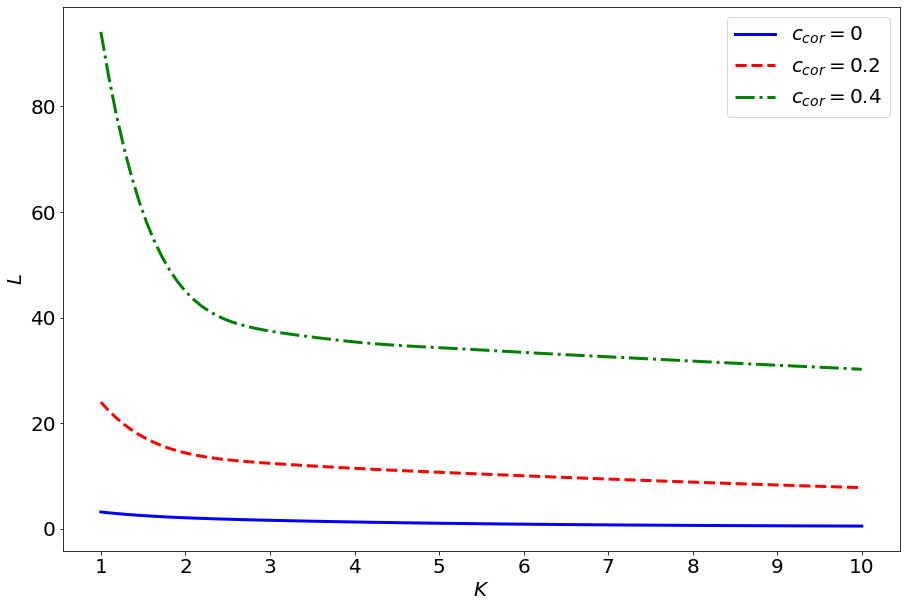

In [109]:
linestyles = ['-', '--', '-.', ':', '-']
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()
K_RANGE = 11
ax.set_prop_cycle(cycler('color', 
                          ['b', 'r', 'g', 'blueviolet']))

labels = ['$c_{cor}=0$', '$c_{cor}=0.2$', '$c_{cor}=0.4$']
x = np.linspace(1, K_RANGE - 1, K_RANGE - 1)
for k, style, b, label in zip(Ks_all, linestyles, b_1s, labels):
    cubic_interploation_model=interp1d(x,k,kind="quadratic")
    tck = interpolate.splrep(x, k, s=0, k=5)
    xs = np.linspace(1, K_RANGE - 1, 100)
    #ys = np.log10(interpolate.splev(xs, tck, der=0))
    ys = interpolate.splev(xs, tck, der=0)
#    xs=np.linspace(1,20,60)
#    ys=cubic_interploation_model(xs)
    ax.plot(xs, ys, label = label, linestyle=style, linewidth=3)

plt.xlabel('$K$', fontsize=20)
plt.ylabel('$L$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc=0);

ax.set_xticks(x)
filename = 'exp_2/K_L'
fig.savefig(f'{filename}.png', format='png', dpi=600)
fig.savefig(f'{filename}.jpg', format='jpg', dpi=600)
plt.show();


In [115]:
columns = ['$c_{cor}$=0','$c_{cor}$=0.2','$c_{cor}$=0.4']
df_K = pd.DataFrame(np.log10(np.array(Ks_all).T), 
             columns=columns,
            index=list(range(1,K_RANGE)))
df_K.to_excel('exp_2/L_log.xlsx')
df_K

,$c_{cor}$=0,$c_{cor}$=0.2,$c_{cor}$=0.4
1,0.505709,1.380378,1.973628
2,0.323556,1.157960,1.653238
3,0.212656,1.094183,1.573584
4,0.117370,1.059608,1.549075
5,0.030670,1.030536,1.535507
6,-0.047773,1.002566,1.524067
7,-0.117526,0.974885,1.513044
8,-0.178328,0.947346,1.502105
9,-0.230255,0.919925,1.491187
10,-0.273728,0.892625,1.480277


In [112]:
columns = ['$c_{cor}$=0','$c_{cor}$=0.2','$c_{cor}$=0.4']
df_K = pd.DataFrame(np.array(Ks_all).T, 
             columns=columns,
            index=list(range(1,K_RANGE)))
df_K.to_excel('exp_2/L.xlsx')
df_K

,$c_{cor}$=0,$c_{cor}$=0.2,$c_{cor}$=0.4
1,3.204119,24.009225,94.108298
2,2.106475,14.386671,45.002641
3,1.631758,12.421762,37.461369
4,1.310298,11.471173,35.405878
5,1.073173,10.728423,34.316849
6,0.895833,10.059265,33.424670
7,0.762911,9.438113,32.586942
8,0.663242,8.858204,31.776421
9,0.588497,8.316207,30.987527
10,0.532442,7.809533,30.218769


In [113]:
columns = ['$c_{cor}$=0','$c_{cor}$=0.2','$c_{cor}$=0.4']
df_rho = pd.DataFrame(np.array(rhos_all).T, 
             columns=columns,
            index=list(range(1,K_RANGE)))
df_rho.to_excel('exp_2/rho.xlsx')
df_rho

,$c_{cor}$=0,$c_{cor}$=0.2,$c_{cor}$=0.4
1,0.802740,0.802740,0.802740
2,0.760459,0.760459,0.760459
3,0.752071,0.752071,0.752071
4,0.750409,0.750409,0.750409
5,0.750081,0.750081,0.750081
6,0.750016,0.750016,0.750016
7,0.750003,0.750003,0.750003
8,0.750001,0.750001,0.750001
9,0.750000,0.750000,0.750000
10,0.750000,0.750000,0.750000


### Experiment 2

In [634]:
b_1s = [0.5, 1, 1.5, 2]
rhos_all = []

D_0, D_1 = Ds[1]
lambd = find_lambda_g()
for b_1 in b_1s:
    h = np.diag(-D_0).max()
    W = len(D_0) - 1
    O = np.matrix(np.zeros((W + 1, W + 1)))
    I = np.matrix(np.identity(W + 1))
    rhos = []
    for K in tqdm(range(1, K_RANGE)):
        cache_clear()
        rhos.append(ergodicity())
    rhos_all.append(rhos)

100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 4428.58it/s]


0.8187307530779818 0.5
0.8015748406169799 0.5
0.8001171521950732 0.5
0.8000082643678802 0.5
0.8000005761213321 0.5
0.8000000402019245 0.5
0.8000000028100093 0.5
0.8000000001965012 0.5
0.8000000000137404 0.5
0.8000000000009605 0.5


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 5319.35it/s]


0.6703200460356393 1
0.6139447545780646 1
0.6027617982299985 1
0.6005456254442972 1
0.6001079505213316 1
0.6000213817391395 1
0.6000042364311606 1
0.6000008394064832 1
0.6000001663191245 1
0.6000000329542367 1


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 5931.70it/s]


0.5488116360940264 1.5
0.44906570123842476 1.5
0.41780020367212556 1.5
0.40671918770492343 1.5
0.40257839063478323 1.5
0.40099580344972635 1.5
0.4003855317484993 1.5
0.4001494003988725 1.5
0.40005791616519704 1.5
0.40002245476826376 1.5


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7523.42it/s]

0.4493289641172216 2
0.3151989221329437 2
0.2624329169854549 2
0.23658136739368135 2
0.22234506496688822 2
0.21397677196511283 2
0.20886744956982115 2
0.20567542003722747 2
0.20365252351758018 2
0.2023589198369303 2


In [209]:
columns = ['$b_1$=0.5','$b_1$=1','$b_1$=1.5', '$b_1$=2']
df_rho = pd.DataFrame(np.array(rhos_all).T, 
             columns=columns,
            index=list(range(1,K_RANGE)))
df_rho.to_excel('exp_1_1/rho.xlsx')
df_rho

,$b_1$=0.5,$b_1$=1,$b_1$=1.5,$b_1$=2
1,0.764500,0.803215,0.862118,0.937551
2,0.751625,0.760908,0.787265,0.836894
3,0.750531,0.752516,0.763802,0.797296
4,0.750450,0.750853,0.755486,0.777896
5,0.750444,0.750525,0.752378,0.767212
6,0.750444,0.750460,0.751191,0.760932
7,0.750444,0.750447,0.750733,0.757098
8,0.750443,0.750444,0.750556,0.754703
9,0.750443,0.750444,0.750487,0.753185
10,0.750443,0.750444,0.750460,0.752214


In [193]:
K_RANGE = 11

Ls_all = []
lambd = find_lambda_g()
for b_1 in b_1s:
    cache_clear()
    Ls = []
    h = np.diag(-D_0).max()
    W = len(D_0) - 1
    O = np.matrix(np.zeros((W + 1, W + 1)))
    I = np.matrix(np.identity(W + 1))
    matrix_size = len(D_0)
    print(ergodicity())
    for K in tqdm(range(1, K_RANGE)):
        cache_clear()
        G_0 = find_G()
        pi_0 = find_pi_0()
        Ls.append(find_L())
    Ls_all.append(Ls)


0.7644998715930141


100%|███████████████████████████████████████████| 10/10 [04:41<00:00, 28.15s/it]


0.7504435244314284


100%|███████████████████████████████████████████| 10/10 [04:53<00:00, 29.35s/it]


0.7504603507360166


100%|███████████████████████████████████████████| 10/10 [05:54<00:00, 35.50s/it]


0.7522137357590761


100%|███████████████████████████████████████████| 10/10 [13:53<00:00, 83.35s/it]


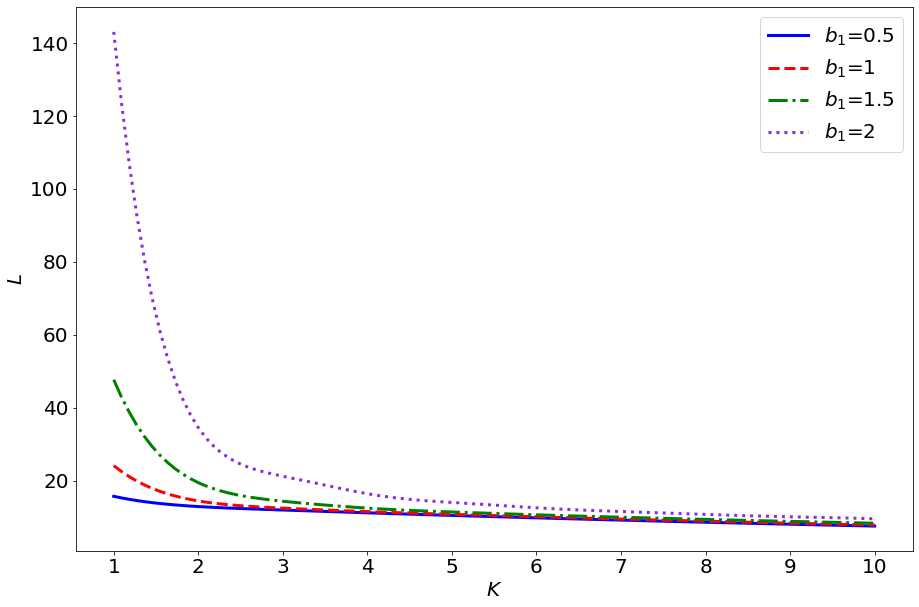

In [511]:
linestyles = ['-', '--', '-.', ':', '-']
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()

ax.set_prop_cycle(cycler('color', 
                          ['b', 'r', 'g', 'blueviolet']))

labels = ['$b_1$=0.5','$b_1$=1','$b_1$=1.5', '$b_1$=2']
x = np.linspace(1, K_RANGE - 1, K_RANGE - 1)
for k, style, b, label in zip(Ls_all, linestyles, b_1s, labels):
    cubic_interploation_model=interp1d(x,k,kind="quadratic")
    tck = interpolate.splrep(x, k, s=0, k=5)
    xs = np.linspace(1, K_RANGE - 1, 100)
    #ys = np.log10(interpolate.splev(xs, tck, der=0))
    ys = interpolate.splev(xs, tck, der=0)
#    xs=np.linspace(1,20,60)
#    ys=cubic_interploation_model(xs)
    ax.plot(xs, ys, label = label, linestyle=style, linewidth=3)

plt.xlabel('$K$', fontsize=20)
plt.ylabel('$L$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc=0);

ax.set_xticks(x)
filename = 'exp_1_1/K_L_b_1'
#fig.savefig(f'{filename}.png', format='png', dpi=600)
#fig.savefig(f'{filename}.jpg', format='jpg', dpi=600)
plt.show();



In [211]:
columns = ['$b_1$=0.5','$b_1$=1','$b_1$=1.5', '$b_1$=2']
df_rho = pd.DataFrame(np.array(Ls_all).T, 
             columns=columns,
            index=list(range(1,K_RANGE)))
df_rho.to_excel('exp_1_1/L.xlsx')
df_rho

,$b_1$=0.5,$b_1$=1,$b_1$=1.5,$b_1$=2
1,15.737831,24.142544,47.685221,143.056004
2,12.927491,14.464104,19.476710,34.559980
3,11.975889,12.490591,14.379347,21.230054
4,11.205624,11.537647,12.496726,16.448138
5,10.493347,10.793531,11.440913,14.051885
6,9.827756,10.123086,10.664196,12.588538
7,9.205344,9.500576,10.006020,11.563883
8,8.623279,8.919224,9.413335,10.772838
9,8.078944,8.375710,8.866863,10.119182
10,7.569893,7.867462,8.358539,9.553919


### Experiment 2

#### N

In [513]:
K_RANGE = 21

Ns_all = []
lambd = find_lambda_g()
for b_1 in b_1s:
    cache_clear()
    Ns = []
    h = np.diag(-D_0).max()
    W = len(D_0) - 1
    O = np.matrix(np.zeros((W + 1, W + 1)))
    I = np.matrix(np.identity(W + 1))
    matrix_size = len(D_0)
    for K in tqdm(range(1, K_RANGE)):
        cache_clear()
        G_0 = find_G()
        pi_0 = find_pi_0()
        Ns.append(find_N())
    Ns_all.append(Ns)

100%|███████████████████████████████████████████| 20/20 [24:07<00:00, 72.36s/it]


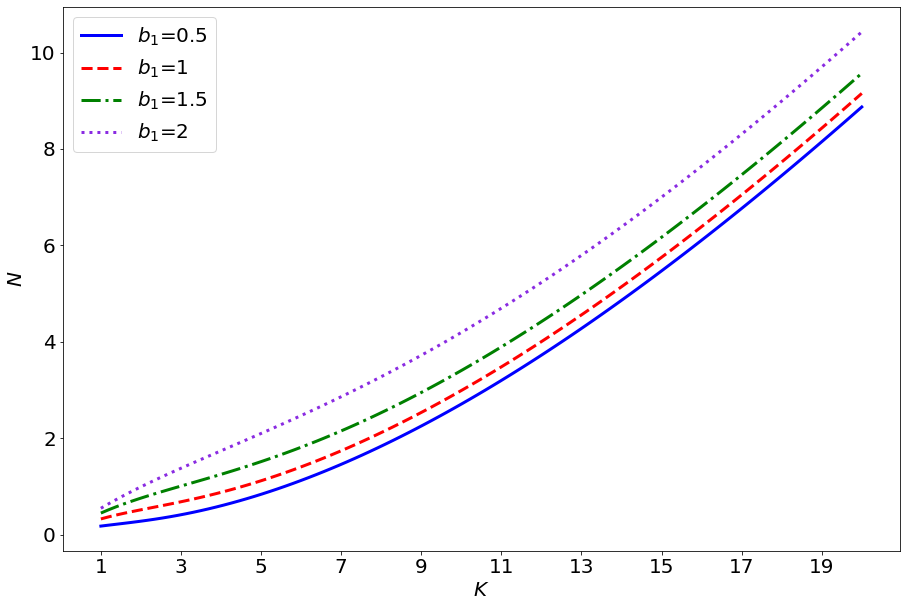

In [516]:
linestyles = ['-', '--', '-.', ':', '-']
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()

ax.set_prop_cycle(cycler('color', 
                          ['b', 'r', 'g', 'blueviolet']))

labels = ['$b_1$=0.5','$b_1$=1','$b_1$=1.5', '$b_1$=2']
x = np.linspace(1, K_RANGE - 1, K_RANGE - 1)
for k, style, b, label in zip(Ns_all, linestyles, b_1s, labels):
    cubic_interploation_model=interp1d(x,k,kind="quadratic")
    tck = interpolate.splrep(x, k, s=0, k=5)
    xs = np.linspace(1, K_RANGE - 1, 100)
    #ys = np.log10(interpolate.splev(xs, tck, der=0))
    ys = interpolate.splev(xs, tck, der=0)
#    xs=np.linspace(1,20,60)
#    ys=cubic_interploation_model(xs)
    ax.plot(xs, ys, label = label, linestyle=style, linewidth=3)

plt.xlabel('$K$', fontsize=20)
plt.ylabel('$N$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc=0);

ax.set_xticks(list(range(1, 21, 2)))
filename = 'exp_1_2/K_N_b_1'
fig.savefig(f'{filename}.png', format='png', dpi=600)
fig.savefig(f'{filename}.jpg', format='jpg', dpi=600)
plt.show();




In [316]:
K_ARRAY = [20]
#p_0s_all = []

#Ns_all = []
lambd = find_lambda_g()
for b_1 in b_1s:
    cache_clear()
    Ns = []
    p_0s = []
    h = np.diag(-D_0).max()
    W = len(D_0) - 1
    O = np.matrix(np.zeros((W + 1, W + 1)))
    I = np.matrix(np.identity(W + 1))
    matrix_size = len(D_0)
    for K in tqdm(K_ARRAY):
        cache_clear()
        G_0 = find_G()
        pi_0 = find_pi_0()
        p_0s.append(float(pi_0 * np.matrix(np.ones(((W + 1) * (K + 1), 1)))))
        Ns.append(find_N())
    p_0s_all.append(p_0s)
    Ns_all.append(Ns)

100%|█████████████████████████████████████████████| 1/1 [01:11<00:00, 71.65s/it]


In [557]:
columns = ['$b_1$=0.5','$b_1$=1','$b_1$=1.5', '$b_1$=2']
df = pd.DataFrame(np.array(Ns_all).T, 
             columns=columns,
            index=list(range(1, 21)))
df.to_excel('exp_1_2/N.xlsx')
df

,$b_1$=0.5,$b_1$=1,$b_1$=1.5,$b_1$=2
1,0.181269,0.329680,0.451188,0.550671
2,0.283159,0.519297,0.761508,0.995599
3,0.416426,0.685566,1.011265,1.380750
4,0.602171,0.880727,1.253933,1.742265
5,0.840317,1.121111,1.517806,2.101959
6,1.127817,1.409056,1.816227,2.472886
7,1.461500,1.742803,2.154286,2.863369
8,1.838374,2.119678,2.532842,3.278757
9,2.255639,2.536945,2.950773,3.722263
10,2.710676,2.991991,3.406147,4.195508


In [337]:
columns = ['$b_1$=0.5','$b_1$=1','$b_1$=1.5', '$b_1$=2']
df = pd.DataFrame(np.array(t).T, 
             columns=columns,
            index=[1, 4, 20])
#df_rho.to_excel('exp_1_1/L.xlsx')
df

,$b_1$=0.5,$b_1$=1,$b_1$=1.5,$b_1$=2
1,0.181269,0.329680,0.451188,0.550671
4,0.602171,0.880727,1.253933,1.742265
20,8.870893,9.152356,9.569442,10.427052


### Experiment 3

In [345]:
K_RANGE = 21

p_0_custom_all = []
lambd = find_lambda_g()
e = np.matrix(np.ones(((W + 1) * (K + 1), 1)))
for b_1 in b_1s:
    cache_clear()
    p_0_custom = []
    h = np.diag(-D_0).max()
    W = len(D_0) - 1
    O = np.matrix(np.zeros((W + 1, W + 1)))
    I = np.matrix(np.identity(W + 1))
    matrix_size = len(D_0)
    for K in tqdm(range(1, K_RANGE)):
        cache_clear()
        G_0 = find_G()
        pi_0 = find_pi_0()
        e = np.matrix(np.ones(((W + 1) * (K + 1), 1)))
        p_0_custom.append(float(pi_0 * e))
    p_0_custom_all.append(p_0_custom)

100%|███████████████████████████████████████████| 20/20 [22:31<00:00, 67.57s/it]


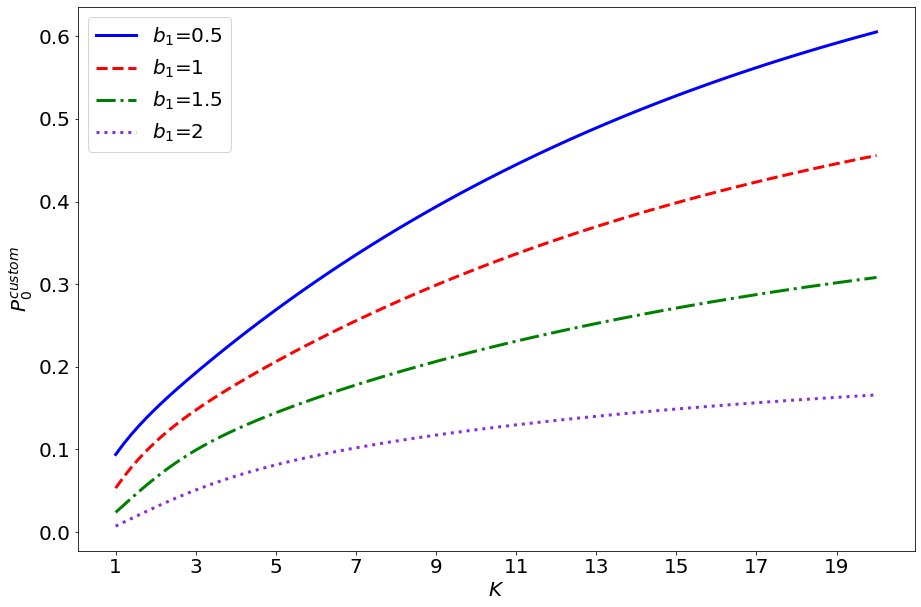

In [504]:
linestyles = ['-', '--', '-.', ':', '-']
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()

ax.set_prop_cycle(cycler('color', 
                          ['b', 'r', 'g', 'blueviolet']))

labels = ['$b_1$=0.5','$b_1$=1','$b_1$=1.5', '$b_1$=2']
x = np.linspace(1, K_RANGE - 1, K_RANGE - 1)
for k, style, b, label in zip(p_0_custom_all, linestyles, b_1s, labels):
    cubic_interploation_model=interp1d(x,k,kind="quadratic")
    tck = interpolate.splrep(x, k, s=0, k=5)
    xs = np.linspace(1, K_RANGE - 1, 100)
    #ys = np.log10(interpolate.splev(xs, tck, der=0))
    ys = interpolate.splev(xs, tck, der=0)
#    xs=np.linspace(1,20,60)
#    ys=cubic_interploation_model(xs)
    ax.plot(xs, ys, label = label, linestyle=style, linewidth=3)

plt.xlabel('$K$', fontsize=20)
plt.ylabel('$P_{0}^{custom}$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc=0);

ax.set_xticks(list(range(1, 21, 2)))
filename = 'exp_1_3/K_P_custom_b_1'
fig.savefig(f'{filename}.png', format='png', dpi=600)
fig.savefig(f'{filename}.jpg', format='jpg', dpi=600)
plt.show();





In [353]:
columns = ['$b_1$=0.5','$b_1$=1','$b_1$=1.5', '$b_1$=2']
df_P_custom = pd.DataFrame(np.array(p_0_custom_all).T, 
             columns=columns,
            index=list(range(1,K_RANGE)))
df_P_custom.to_excel('exp_1_3/P_custom.xlsx')
df_P_custom

,$b_1$=0.5,$b_1$=1,$b_1$=1.5,$b_1$=2
1,0.093804,0.053115,0.023673,0.007161
2,0.149388,0.109223,0.065774,0.030206
3,0.192694,0.147578,0.099099,0.050836
4,0.232143,0.178500,0.124041,0.067708
5,0.268937,0.206203,0.144347,0.081290
6,0.303336,0.231825,0.162040,0.092452
7,0.335504,0.255712,0.178036,0.101887
8,0.365586,0.278027,0.192755,0.110066
9,0.393718,0.298887,0.206408,0.117301
10,0.420026,0.318391,0.219120,0.123797


### Experiment 4

In [481]:
K_RANGE = 21

p_0_energy_all = []
lambd = find_lambda_g()
e = np.matrix(np.ones(((W + 1) * (K + 1), 1)))
for b_1 in b_1s:
    cache_clear()
    p_0_energy = []
    h = np.diag(-D_0).max()
    W = len(D_0) - 1
    O = np.matrix(np.zeros((W + 1, W + 1)))
    I = np.matrix(np.identity(W + 1))
    matrix_size = len(D_0)
    for K in tqdm(range(1, K_RANGE)):
        cache_clear()
        G_0 = find_G()
        pi_0 = find_pi_0()
        e = np.matrix(np.ones(((W + 1) * (K + 1), 1)))
        p_0_energy.append(find_P_energy())
    p_0_energy_all.append(p_0_energy)

100%|███████████████████████████████████████████| 20/20 [23:25<00:00, 70.29s/it]


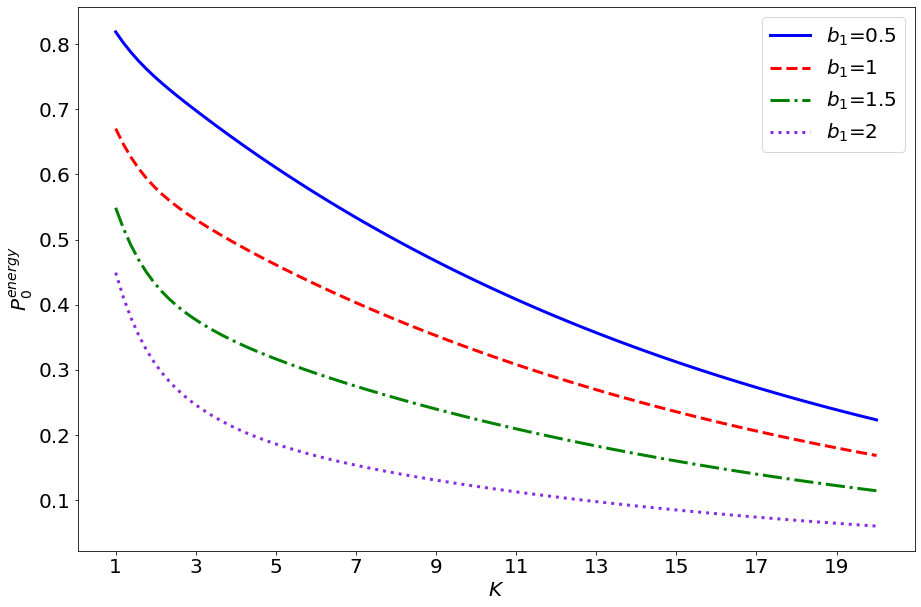

In [501]:
linestyles = ['-', '--', '-.', ':', '-']
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()

ax.set_prop_cycle(cycler('color', 
                          ['b', 'r', 'g', 'blueviolet']))

labels = ['$b_1$=0.5','$b_1$=1','$b_1$=1.5', '$b_1$=2']
x = np.linspace(1, K_RANGE - 1, K_RANGE - 1)
for k, style, b, label in zip(p_0_energy_all, linestyles, b_1s, labels):
    cubic_interploation_model=interp1d(x,k,kind="quadratic")
    tck = interpolate.splrep(x, k, s=0, k=5)
    xs = np.linspace(1, K_RANGE - 1, 100)
    #ys = np.log10(interpolate.splev(xs, tck, der=0))
    ys = interpolate.splev(xs, tck, der=0)
#    xs=np.linspace(1,20,60)
#    ys=cubic_interploation_model(xs)
    ax.plot(xs, ys, label = label, linestyle=style, linewidth=3)

plt.xlabel('$K$', fontsize=20)
plt.ylabel('$P_{0}^{energy}$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc=0);

ax.set_xticks(list(range(1, 21, 2)))
filename = 'exp_1_4/K_P_energy_b_1'
fig.savefig(f'{filename}.png', format='png', dpi=600)
fig.savefig(f'{filename}.jpg', format='jpg', dpi=600)
plt.show();






In [486]:
columns = ['$b_1$=0.5','$b_1$=1','$b_1$=1.5', '$b_1$=2']
df_P_energy = pd.DataFrame(np.array(p_0_energy_all).T, 
             columns=columns,
            index=list(range(1,K_RANGE)))
df_P_energy.to_excel('exp_1_4/P_energy.xlsx')
df_P_energy

,$b_1$=0.5,$b_1$=1,$b_1$=1.5,$b_1$=2
1,0.818731,0.670320,0.548812,0.449329
2,0.748425,0.578845,0.431050,0.308374
3,0.698269,0.530782,0.376989,0.246409
4,0.652840,0.493968,0.342933,0.210607
5,0.610500,0.461359,0.316925,0.186399
6,0.570922,0.431283,0.294807,0.168290
7,0.533913,0.403265,0.274991,0.153773
8,0.499305,0.377097,0.256818,0.141558
9,0.466939,0.352640,0.239981,0.130931
10,0.436672,0.329774,0.224311,0.121472


### Experiment 5

In [488]:
K_RANGE = 21

p_0_idle_all = []
lambd = find_lambda_g()
e = np.matrix(np.ones(((W + 1) * (K + 1), 1)))
for b_1 in b_1s:
    cache_clear()
    p_0_idle = []
    h = np.diag(-D_0).max()
    W = len(D_0) - 1
    O = np.matrix(np.zeros((W + 1, W + 1)))
    I = np.matrix(np.identity(W + 1))
    matrix_size = len(D_0)
    for K in tqdm(range(1, K_RANGE)):
        cache_clear()
        G_0 = find_G()
        pi_0 = find_pi_0()
        e = np.matrix(np.ones(((W + 1) * (K + 1), 1)))
        p_0_idle.append(find_P_idle())
    p_0_idle_all.append(p_0_idle)

100%|███████████████████████████████████████████| 20/20 [24:24<00:00, 73.23s/it]


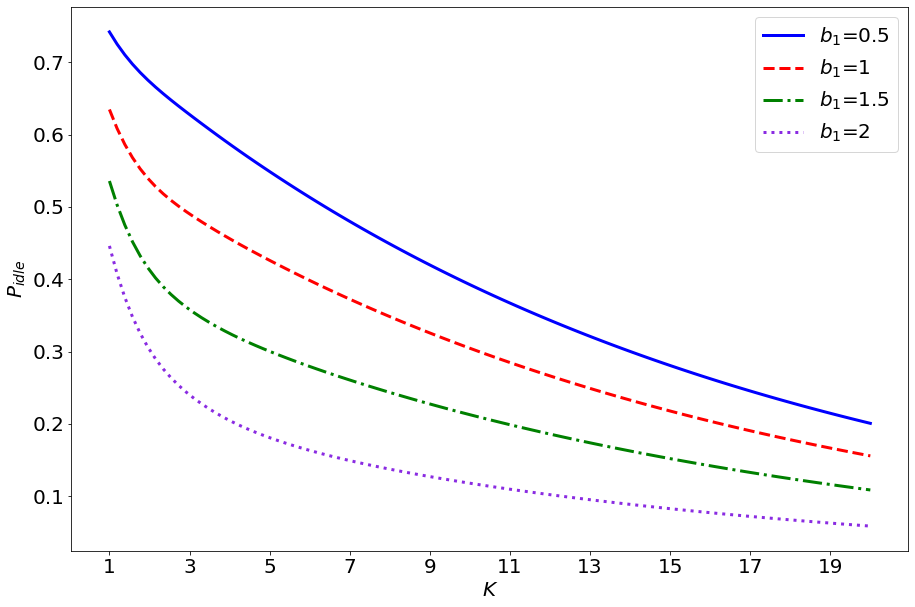

In [498]:
linestyles = ['-', '--', '-.', ':', '-']
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()

ax.set_prop_cycle(cycler('color', 
                          ['b', 'r', 'g', 'blueviolet']))

labels = ['$b_1$=0.5','$b_1$=1','$b_1$=1.5', '$b_1$=2']
x = np.linspace(1, K_RANGE - 1, K_RANGE - 1)
for k, style, b, label in zip(p_0_idle_all, linestyles, b_1s, labels):
    cubic_interploation_model=interp1d(x,k,kind="quadratic")
    tck = interpolate.splrep(x, k, s=0, k=5)
    xs = np.linspace(1, K_RANGE - 1, 100)
    #ys = np.log10(interpolate.splev(xs, tck, der=0))
    ys = interpolate.splev(xs, tck, der=0)
#    xs=np.linspace(1,20,60)
#    ys=cubic_interploation_model(xs)
    ax.plot(xs, ys, label = label, linestyle=style, linewidth=3)

plt.xlabel('$K$', fontsize=20)
plt.ylabel('$P_{idle}$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc=0);


ax.set_xticks(list(range(1, 21, 2)))
filename = 'exp_1_5/K_P_idle_b_1'
fig.savefig(f'{filename}.png', format='png', dpi=600)
fig.savefig(f'{filename}.jpg', format='jpg', dpi=600)
plt.show();







In [636]:
columns = ['$b_1$=0.5','$b_1$=1','$b_1$=1.5', '$b_1$=2']
df_P_idle = pd.DataFrame(np.array(p_0_idle_all).T, 
             columns=columns,
            index=list(range(1,K_RANGE)))
#df_P_energy.to_excel('exp_5/P_idle.xlsx')
df_P_idle

ValueError: Shape of passed values is (20, 4), indices imply (10, 4)

$$\theta D(1)=0, \theta e = 1$$

In [63]:
def find_theta():
    W = len(D_0) - 1
    a = np.concatenate((
    np.delete((D_0 + D_1), 0, 1).transpose(), 
    np.ones([W + 1, 1]).transpose()))
    b = np.concatenate((np.zeros([W, 1]), np.matrix(1)))
    return LA.solve(a = a, b = b).T

In [533]:
theta = find_theta()
theta

matrix([[0.73102212, 0.26897788]])

$$\lambda=\theta D_1e$$

In [64]:
def find_lambda():
    theta = find_theta()
    e = np.matrix(np.ones(((W + 1), 1)))
    return float(theta * D_1 * e)

In [535]:
find_lambda()

0.3001773998804549

$$\lambda_g=-\theta D_0e$$

In [65]:
def find_lambda_g():
    theta = find_theta()
    e = np.matrix(np.ones(((W + 1), 1)))
    return float(-theta * D_0 * e)

In [929]:
lambda_g = find_lambda_g()
lambda_g

-1.2960370688145906

In [66]:
def set_lambda(D_0, D_1):
    e = np.matrix(np.ones(((W + 1), 1)))

    theta = find_theta()
    lambda_g = find_lambda_g()
    D_0_new = D_0  * lambd / lambda_g
    D_1_new = D_1 * lambd / lambda_g 
    temp = np.zeros((W + 1, W + 1))
    temp[-1] = ((D_0_new + D_1_new) * e).T
    D_1_new = D_1_new - temp.T
    return D_0_new.copy(), D_1_new.copy()

In [930]:
D_0, D_1 = set_lambda(D_0, D_1)

$$c_{var}^2=2\lambda_b\theta(-D_0)^{-1}e-1$$

In [67]:
def find_c_var():
    e = np.matrix(np.ones(((W + 1), 1)))
    return float(2 * lambda_g * theta * (-D_0)**(-1) * e - 1)

In [71]:
D_0 = np.matrix([
    [-1.35, 0],
    [0, -0.034]
])

D_1 = np.matrix([
    [1.34811, 0.05],
    [0.005, 0.21]
])
cache_clear()
D_0, D_1 = set_lambda(D_0, D_1)
cache_clear()
theta = find_theta()
lambda_g = find_lambda_g()
c_var = find_c_var()
c_cor = find_c_cor()
c_cor, c_var

(0.3991961615807982, 16.021816529511618)

In [100]:
D_0, D_1 = set_lambda(D_0, D_1)
cache_clear()
theta = find_theta()
lambda_g = find_lambda_g()
c_var = find_c_var()
c_cor = find_c_cor()
c_cor, c_var

(0.3991955425446128, 16.021599842554053)

In [1253]:
Ds[1:]

[(matrix([[-0.40578 ,  0.      ],
          [ 0.      , -0.013173]]),
  matrix([[0.40308 , 0.0027  ],
          [0.007338, 0.005835]])),
 (matrix([[-0.21632047,  0.        ],
          [ 0.        , -0.00544807]]),
  matrix([[0.21601763, 0.00030285],
          [0.00080119, 0.00464688]]))]

In [1238]:
Ds[2] = D_0.copy(), D_1.copy()

In [1145]:
D_0, D_1 = Ds[2]

In [89]:
for x in Ds[2:]:
    print(x)

(matrix([[-0.21632047,  0.        ],
        [ 0.        , -0.00544807]]), matrix([[0.21601763, 0.00030285],
        [0.00080119, 0.00464688]]))


In [87]:
D_0

matrix([[-0.40950161,  0.        ],
        [ 0.        , -0.01031337]])

In [93]:
cache_clear()

In [94]:
c_var = find_c_var()
c_var

16.021599842553982

$$c_{cor}=(\lambda_g\theta(-D_0)^{-1}(D(1)-D_0)(-D_0)^{-1}e-1)/c_{var}^2$$

In [69]:
def find_c_cor():
    e = np.matrix(np.ones(((W + 1), 1)))
    return float((lambda_g*theta*(-D_0)**(-1)*D_1*(-D_0)**(-1)*e - 1) / c_var)

In [95]:
theta = find_theta()
lambda_g = find_lambda_g()

In [96]:
c_cor = find_c_cor()
c_cor

0.3991955425446127

$$N = \sum\limits_{i=0}^{\infty}\sum\limits_{k=1}^{K}k\pi(i, k)e$$

In [70]:
def find_N(): 
    i = 0
    norm = 1
    summa = 0
    e = np.matrix(np.ones(((W + 1), 1)))
    while norm > epsilon_f:
        pi = pi_l(i).reshape((K + 1, W + 1))
        element = 0
        for k in range(1, K + 1):
            element += k * pi[k] * e
        summa += element
        norm = element
        i +=1 
    return float(summa)

In [276]:
find_N()

10.427051664654375

$$P_0^{custom}=\pi_0e$$

In [475]:
def P_custom():
    e = np.matrix(np.ones(((W + 1) * (K + 1), 1)))
    return float(pi_0 * e)

$$P_0^{energy}=\sum\limits_{i=0}^{\infty}\pi(i, 0)e$$

In [479]:
def find_P_energy():
    i = 0
    norm = 1
    summa = 0
    e = np.matrix(np.ones(((W + 1), 1)))
    while norm > epsilon_f:
        pi = pi_l(i).reshape((K + 1, W + 1))[0]
        element = pi * e
        summa += element
        norm = element
        i +=1 
    return float(summa)

$$P_0^{idle}=\sum\limits_{i=1}^{\infty}\pi(i, 0)e$$

In [487]:
def find_P_idle():
    i = 1
    norm = 1
    summa = 0
    e = np.matrix(np.ones(((W + 1), 1)))
    while norm > epsilon_f:
        pi = pi_l(i).reshape((K + 1, W + 1))[0]
        element = pi * e
        summa += element
        norm = element
        i +=1 
    return float(summa)

$$\tau=b_1+\pi(0,0)(-D_0+\gamma I)^{-1}(D_1\gamma^{-1}+\gamma(-D_0)^{-1})e+\gamma^{-1}\sum\limits_{i=1}^{\infty}\pi(i,0)e+\sum\limits_{k=1}^{K}\pi(0,k)(-D_0)^{-1}e$$

In [430]:
def find_tau():
    W = len(D_0) - 1
    pi = pi_l(0).reshape((K + 1, W + 1))
    e = np.matrix(np.ones(((W + 1), 1)))
    
    i = 1
    norm = 1
    summa_1 = 0
    e = np.matrix(np.ones(((W + 1), 1)))
    while norm > epsilon_f:
        pi_i = pi_l(i).reshape((K + 1, W + 1))[0]
        element = pi_i * e
        summa_1 += element
        norm = element
        i +=1 
    summa_1 /= gamma
    
    summa_2 = 0
    for k in range(1, K + 1):
        summa_2 += pi[k] * (-D_0)**(-1)*e
    
    return float(b_1 + pi[0] * (-D_0 + gamma * I)**(-1) * (D_1 / gamma + gamma * (-D_0)**(-1)) * e + summa_1 + summa_2)

In [472]:
cache_clear()
G_0 = find_G()
pi_0 = find_pi_0()

In [473]:
find_lambda_g()

0.3001773998804543

In [474]:
1 / find_tau()

0.30474722251873254

In [446]:
D_0, D_1 = Ds[1]

In [469]:
K=4
b_1 = 1

In [470]:
epsilon = 1e-7
epsilon_f = 1e-10
epsilon = 1e-7
cache_clear()

In [ ]:
fig = plt.figure(figsize=(15, 10))
x = np.linspace(1, 20, 20)
y = Ks_all[1]
tck = interpolate.splrep(x, y, s=0, k=5)
xnew = np.linspace(1, 20, 100)
ynew = interpolate.splev(xnew, tck, der=0)
plt.plot(x, y)
plt.plot(xnew, ynew)
plt.show()